In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score


c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('input/spotify_songs.csv', sep=',')

songs = df[['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
print(songs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist_genre    32833 non-null  object 
 1   danceability      32833 non-null  float64
 2   energy            32833 non-null  float64
 3   key               32833 non-null  int64  
 4   loudness          32833 non-null  float64
 5   mode              32833 non-null  int64  
 6   speechiness       32833 non-null  float64
 7   acousticness      32833 non-null  float64
 8   instrumentalness  32833 non-null  float64
 9   liveness          32833 non-null  float64
 10  valence           32833 non-null  float64
 11  tempo             32833 non-null  float64
 12  duration_ms       32833 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 3.3+ MB
None


In [21]:
songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [3]:
# Remove duplicates
duplicates = songs.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

songs = songs.drop_duplicates()


Number of duplicate rows:  3041


In [23]:
print("Total number of songs: ", len(songs))
print(songs['playlist_genre'].value_counts())

Total number of songs:  29792
playlist_genre
rap      5433
edm      5400
r&b      5041
pop      5012
latin    4578
rock     4328
Name: count, dtype: int64


In [4]:
min = songs['playlist_genre'].value_counts().min()
# Take only min songs from each genre
songs = songs.groupby('playlist_genre').head(min)

In [5]:
map_genres = {genre: i for i, genre in enumerate(songs['playlist_genre'].unique())}
map_genres 

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [6]:
songs_data = songs.drop('playlist_genre', axis=1)
songs_target = songs['playlist_genre']
songs_target = songs_target.map(map_genres)

# Normalize data to 0-1 range
songs_data = (songs_data - songs_data.min()) / (songs_data.max() - songs_data.min())

songs_data_train, songs_data_test, songs_target_train, songs_target_test = train_test_split(songs_data, songs_target, test_size=0.3, random_state=0)
songs_data_test, songs_data_val, songs_target_test, songs_target_val = train_test_split(songs_data_test, songs_target_test, test_size=0.5, random_state=0)

print("Training set size: ", len(songs_data_train))
print("Test set size: ", len(songs_data_test))
print("Validation set size: ", len(songs_data_val))

Training set size:  18177
Test set size:  3895
Validation set size:  3896


In [7]:
# only train-test split (for cross validation)
songs_data_train2, songs_data_test2, songs_target_train2, songs_target_test2 = train_test_split(songs_data, songs_target, test_size=0.3, random_state=0)

print("Training set size: ", len(songs_data_train2))
print("Test set size: ", len(songs_data_test2))

Training set size:  18177
Test set size:  7791


# Models

## KNeighborsClassifier

In [8]:
# KNeighborsClassifier
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train, songs_target_train)

    y_pred = knn_model.predict(songs_data_val)
    accuracy = accuracy_score(songs_target_val, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.sort_values('accuracy', ascending=False)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:47<00:00,  1.40s/it]


,k,accuracy
14,15,0.457136
24,25,0.457136
32,33,0.456879
26,27,0.456879
18,19,0.456366
25,26,0.455339
27,28,0.454569
28,29,0.453542
17,18,0.453029
30,31,0.453029


In [31]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(songs_data_train, songs_target_train)
y_pred = knn_model.predict(songs_data_test)
accuracy = accuracy_score(songs_target_test, y_pred)
print(accuracy)

0.4500641848523748


In [45]:
# cross validation
res = []
for k in np.arange(1,25):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,songs_data_test2,songs_target_test2,cv=5)
    res.append({'K':k, 'err_rate': er})

In [46]:
results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
20,21,0.423822


In [47]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=21)
knn_model.fit(songs_data_train2, songs_target_train2)
y_pred = knn_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print(accuracy)

0.452958541907329


## Naive bayes classifier

In [16]:
# Naive bayes classifier
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train, songs_target_train)
y_pred = naive_bayes_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)

print(accuracy)

0.43993839835728954


In [48]:
# accuracy on test set
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train2, songs_target_train2)
y_pred = naive_bayes_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)

print(accuracy)

0.4420485175202156


Each feature has the same influence on the decision.

## Decision tree

In [13]:
# Decision tree
decision_tree_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [7,9,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [6,7,8]
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(songs_data_train, songs_target_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best params:", best_params)

y_pred = best_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

Best params: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 8}
0.45585215605749485


In [15]:
# feature importances
best_model.feature_importances_

array([0.17739404, 0.09192767, 0.00604568, 0.06356691, 0.00300473,
       0.20183013, 0.05447717, 0.08677825, 0.00766335, 0.07231996,
       0.14842794, 0.08656417])

In [30]:
feature_importances_dt = pd.Series(best_model.feature_importances_, index=songs_data_train.columns)
feature_importances_dt

danceability        0.177394
energy              0.091928
key                 0.006046
loudness            0.063567
mode                0.003005
speechiness         0.201830
acousticness        0.054477
instrumentalness    0.086778
liveness            0.007663
valence             0.072320
tempo               0.148428
duration_ms         0.086564
dtype: float64

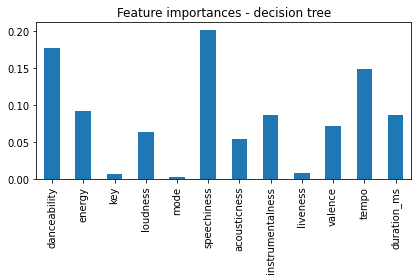

In [31]:
fig, ax = plt.subplots()
feature_importances_dt.plot.bar(ax=ax)
ax.set_title("Feature importances - decision tree")
fig.tight_layout()

## Random forest

In [10]:
# Random forest
random_forest_model = RandomForestClassifier(n_estimators=105, random_state=42)
random_forest_model.fit(songs_data_train, songs_target_train)
y_pred = random_forest_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

# hyperparameter tunning???

0.5141170431211499


In [11]:
# feature importances
random_forest_model.feature_importances_

array([0.11664049, 0.09430144, 0.04513025, 0.08561509, 0.01343936,
       0.12335856, 0.08947298, 0.07245947, 0.06727818, 0.09021271,
       0.11112308, 0.09096838])

In [27]:
feature_importances_rf = pd.Series(random_forest_model.feature_importances_, index=songs_data_train.columns)
feature_importances_rf

danceability        0.116640
energy              0.094301
key                 0.045130
loudness            0.085615
mode                0.013439
speechiness         0.123359
acousticness        0.089473
instrumentalness    0.072459
liveness            0.067278
valence             0.090213
tempo               0.111123
duration_ms         0.090968
dtype: float64

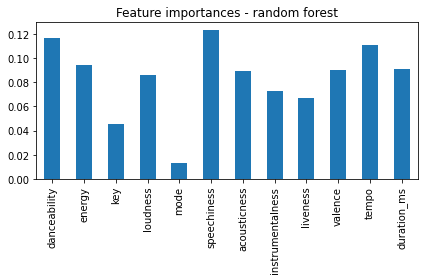

In [28]:
fig, ax = plt.subplots()
feature_importances_rf.plot.bar(ax=ax)
ax.set_title("Feature importances - random forest")
fig.tight_layout()

## Support Vector Machine

In [12]:
# Support Vector Machine
clf = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)
clf.fit(songs_data_train, songs_target_train)
y_pred = clf.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5033367556468172


#### Extra models
Gradient Boosting

XGBoost

AdaBoost

Multiclass logistic regression